## Import Package

In [1]:
import graphviz
from sklearn import tree

from decision_tree_functions import *
from helper_functions import *

## Titanic Data Set (Classification Task)

### 1 Data Preparation

In [11]:
df = pd.read_csv("data/Titanic.csv")
df["label"] = df.Survived
df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
# handling string values
str_convert_float(df)
# handling missing values
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]
df = df.fillna({"Age": median_age, "Embarked": mode_embarked})
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,label
0,3,0,22.0,1,0,7.2500,0,0
1,1,1,38.0,1,0,71.2833,1,1
2,3,1,26.0,0,0,7.9250,0,1
3,1,1,35.0,1,0,53.1000,0,1
4,3,0,35.0,0,0,8.0500,0,0


### 2 Split Data Set

In [12]:
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
max_depth = 16

### 3 Compare Different Models

#### 3.1 Tree Without Pruning

In [13]:
my_tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=max_depth)
predictions = make_predictions(df_test, my_tree)
predictions_correct = predictions == df_test.label
print(f"Accuracy of Tree:         {predictions_correct.mean()}")
pd.crosstab(df_test.label, predictions, rownames=["label"], colnames=["prediction"])

Accuracy of Tree:         0.7313432835820896


prediction,0,1
label,,
0,68,20
1,16,30


#### 3.2 Tree With Pruning

In [14]:
my_tree_pruned = post_pruning(my_tree, df_train, df_val, ml_task="classification")
predictions = make_predictions(df_test, my_tree_pruned)
predictions_correct = predictions == df_test.label
print(f"Accuracy of pruned Tree:  {predictions_correct.mean()}")
pd.crosstab(df_test.label, predictions, rownames=["label"], colnames=["prediction"])

Accuracy of pruned Tree:  0.8208955223880597


prediction,0,1
label,,
0,78,10
1,14,32


#### 3.3 Tree With Sklearn

In [15]:
skl_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
skl_tree.fit(df_train.drop(["label"], axis=1), df_train.label)
predictions = skl_tree.predict(df_test.drop(["label"], axis=1))
predictions_correct = predictions == df_test.label
print(f"Accuracy of sklearn Tree: {predictions_correct.mean()}")
pd.crosstab(df_test.label, predictions, rownames=["label"], colnames=["prediction"])

Accuracy of sklearn Tree: 0.746268656716418


prediction,0,1
label,,
0,70,18
1,16,30


### 4 Visualizing decision tree.

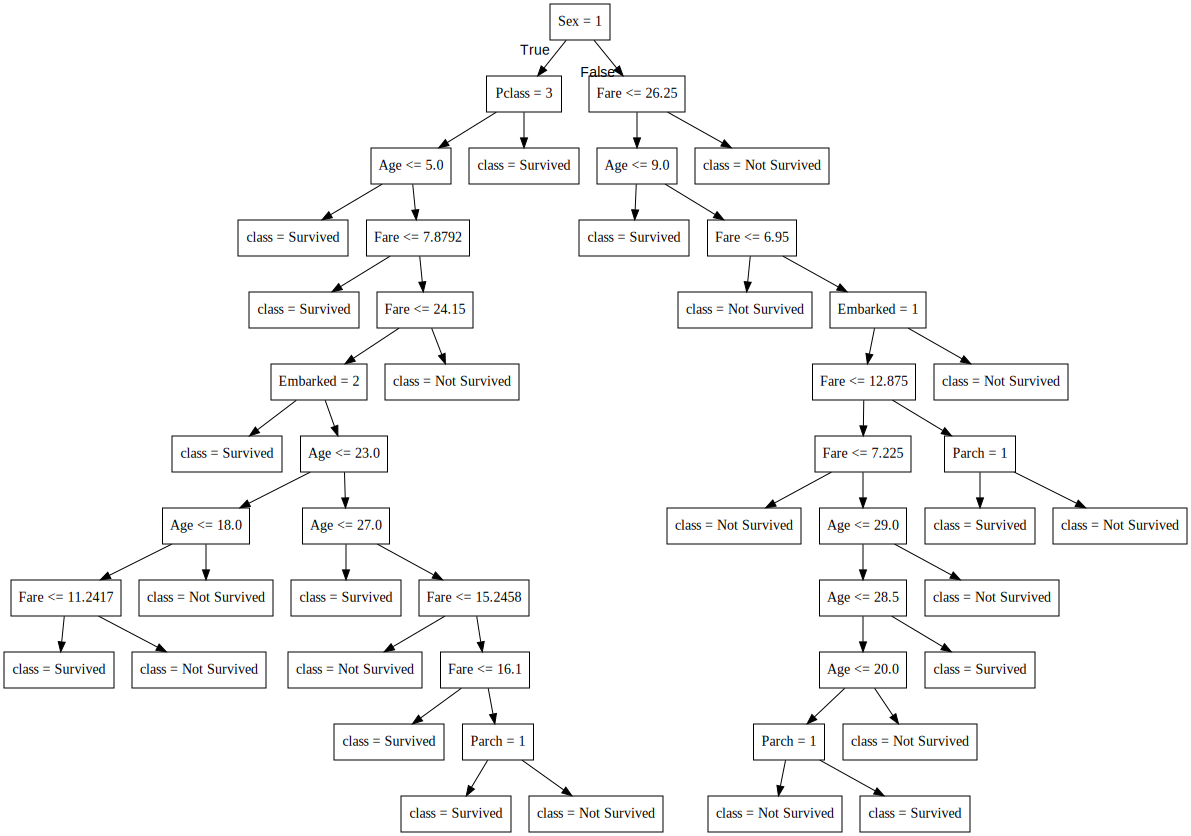

In [16]:
dot_data = tree_graph(my_tree_pruned, {1: "Survived", 0: "Not Survived"})
graphviz.Source(dot_data)

## Bike Rental Data Set (Regression Task)

### 1 Data Preparation

In [19]:
df = pd.read_csv("data/Bike.csv", parse_dates=["dteday"])
df = df.drop(["instant", "casual", "registered"], axis=1)
df = df.rename({"dteday": "date"}, axis=1)

date_column = df.date

df["day_of_year"] = date_column.dt.dayofyear
df["day_of_month"] = date_column.dt.day

df["quarter"] = date_column.dt.quarter
df["week"] = date_column.dt.week

df["is_month_end"] = date_column.dt.is_month_end
df["is_month_start"] = date_column.dt.is_month_start
df["is_quarter_end"] = date_column.dt.is_quarter_end
df["is_quarter_start"] = date_column.dt.is_quarter_start
df["is_year_end"] = date_column.dt.is_year_end
df["is_year_start"] = date_column.dt.is_year_start

df = df.set_index("date")

df["label"] = df.cnt
df = df.drop("cnt", axis=1)

df_train = df.iloc[:-122]
df_val = df.iloc[-122:-61]  # Sep and Oct of 2012
df_test = df.iloc[-61:]  # Nov and Dec of 2012
df_test.head()

<ipython-input-19-34ad908563bd>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week"] = date_column.dt.week


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,day_of_month,quarter,week,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,label
date,,,,,,,,,,,,,,,,,,,,,
2012-11-01,4,1,11,0,4,1,2,0.365833,0.369942,0.581667,...,1,4,44,False,True,False,False,False,False,5986
2012-11-02,4,1,11,0,5,1,1,0.355000,0.356042,0.522083,...,2,4,44,False,False,False,False,False,False,5847
2012-11-03,4,1,11,0,6,0,2,0.343333,0.323846,0.491250,...,3,4,44,False,False,False,False,False,False,5138
2012-11-04,4,1,11,0,0,0,1,0.325833,0.329538,0.532917,...,4,4,44,False,False,False,False,False,False,5107
2012-11-05,4,1,11,0,1,1,1,0.319167,0.308075,0.494167,...,5,4,45,False,False,False,False,False,False,5259


### 2 Compare Different Models

#### 2.1 Tree Without Pruning

In [20]:
my_tree = decision_tree_algorithm(df_train, ml_task="regression", max_depth=10)
rss_tree = determine_errors(df_test, my_tree, ml_task="regression")
print(f"RSS of Tree:         {int(rss_tree):,}")

RSS of Tree:         138,737,362


#### 2.2 Tree With Pruning

In [21]:
my_tree_pruned = post_pruning(my_tree, df_train, df_val, ml_task="regression")
rss_tree_pruned = determine_errors(df_test, my_tree_pruned, ml_task="regression")
print(f"RSS of pruned Tree:  {int(rss_tree_pruned):,}")

RSS of pruned Tree:  95,122,567


#### 2.3 Tree With Sklearn

In [22]:
skl_tree = tree.DecisionTreeRegressor(max_depth=max_depth)
skl_tree.fit(df_train.drop(["label"], axis=1), df_train.label)
predictions = skl_tree.predict(df_val.drop(["label"], axis=1))
rss_tree_sklearn = ((predictions - df_val.label) ** 2).sum()
print(f"RSS of sklearn Tree: {int(rss_tree_sklearn):,}")

RSS of sklearn Tree: 117,164,292


#### 2.3 Compare With Plot

<AxesSubplot:xlabel='date'>

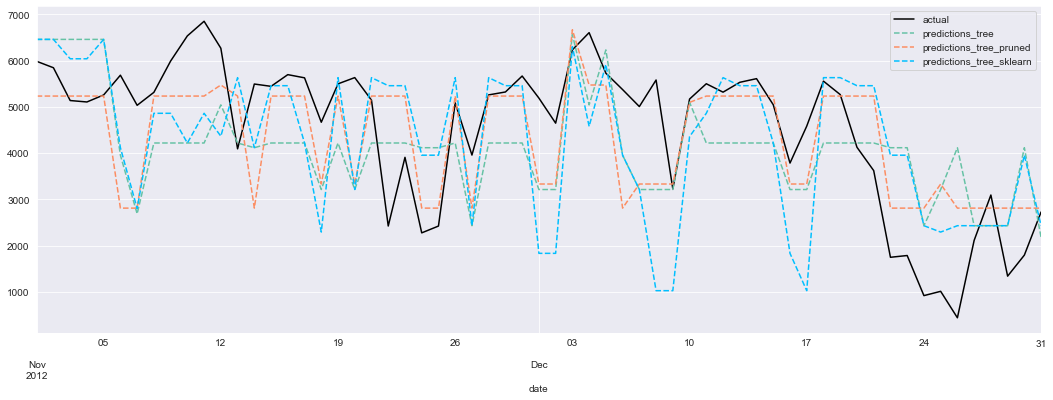

In [23]:
df_plot = pd.DataFrame({"actual": df_test.label,
                        "predictions_tree": make_predictions(df_test, my_tree),
                        "predictions_tree_pruned": make_predictions(df_test, my_tree_pruned),
                        "predictions_tree_sklearn": skl_tree.predict(df_test.drop(["label"], axis=1))})
df_plot.plot(figsize=(18, 6), color=["black", "#66c2a5", "#fc8d62", "#00BFFF"], style=["-", "--", "--", "--"])